# Bayesian Networks for Estimating Attack Vector

## Intro & motivating example
- High-level overview of what this tutorial covers (i.e. a plain-language description: "Bayesian networks offer a way to model causality in the language of probabilities, providing a more compact representation of the probabilistic relationships between variables")
- Motivating star wars^tm example from project description
- More detailed list of topics/methods covered and how they relate to the example. i.e. give an outline of the rest of the tutorial.

### References
- \[AIMA\] Chapter 13, 14
- [R. Dechter, "Bucket Elimination: A Unifying Framework for Probabilistic Inference"](https://webdocs.cs.ualberta.ca/~rgreiner/C-366/RG-2002-SLIDES/BucketElim.pdf) 

## Probability Review
- This section won't provide a huge overview of probability, but just a reminder of the relevant parts.
- Random variables and joint probability distributions (for n binary variables, requires 2^n storage)
- Reasoning using joint distributions (13.3)
    - just read out e.g. P(A ^ B)
    - marginalization to get marginal probability e.g. just P(A) = P(A ^ B) + P(A ^ !B) (plus general eq.)
    - Conditional/posterior probabilities, product rule P(A ^ B) = P(A | B)P(B), and conditioning (marginalization but with conditional probs).
    - Derive P(X|e) = P(X^e)/P(e) = aP(X^e) = a \sum_y P(X, e, y) (normalization to get a so that P(X|e)+P(!X|e)=1
    - Remark: this would allow us to answer whatever queries we want to ask just by looking in the joint distribution table. BUT that table has size O(2^n) and requires O(2^n) to process by summing over it.
- Reasoning using conditional distributions (13.4)
    - Lots of redundant information in full joint distribution (like how your toothache affects the weather, ignoring causality)
    - Independence! Conditional independence (based on causality)!
    - Allows factoring the joint distribution into multiple smaller conditional distributions, saving on size. 2^n+2^m << 2^{n+m}    

## Bayesian Networks
- Smooth segue: how do we formalize these conditional distributions into an easy-to-use data structure?
- What is a Bayesian network
    - Define the data structure (p511)
    - Remark on how it encodes causality via conditional independence (siblings conditionally independent of each other) and independence (unconnected networks are independent).
- Simple example
    - How to construct theoretically
    - How to construct with the python class

In [ ]:
# Example code for constructing the simple burglary example from AIMA (Fig. 14.2) goes here

- What can they do for you (with reference to the simple example)?
    - Answer queries on the joint probability distribution e.g. P(a, b, !c, d, !e) = \product_i P(x_i | parents(x_i))
    - Query the posterior given evidence e.g. P(X | e) = aP(X, e) = a \sum_{y not x not e} P(X, e, y) <- same as above
    - MAP: max liklihood explanation, the X with the highest probability given e.

## Brute Force Method
- Describe brute-force method for getting probability estimates
    - 14.4.1
    - O(n2^n) for n vars

In [ ]:
def brute_force_query(X, e, net):
    """Returns the posterior probability P(x | e) using the Bayesian network `net`,
    using a brute force enumeration method with time complexity O(n2^n), where
    n is the number of variables in the network.
    
    Inputs:
        X: a list of variable names for which we will calculate posteriors
        e: a list of tuples (name, value) specifying assignments to evidence variables
            (we assume that e and X are disjoint)
    Outputs:
        P: a distribution over the query variables in X (a dict mapping names in
           X to a probability value)
    """
    pass

- benchmark the brute force algorithm to show how exponential it is
    - Simple example from last section
    - Star wars example from this section

In [ ]:
# Run brute_force_query on the two examples to see how long they take

- Simple speedup via DFS enumeration-ask alg from book fig 14.9
    - Explain how it works
    - Still super slow: O(2^n) for n

In [ ]:
# CITE: Russel & Norvig AIMA Ch 14, Section 4, Fig. 14.9
def simple_query(X, e, net):
    """Returns the posterior probability P(x | e) using the Bayesian network `net`,
    using an improved enumeration method with time complexity O(2^n), where n is
    the number of variables in the network, using analogue to depth-first search.
    
    Inputs:
        X: a list of variable names for which we will calculate posteriors
        e: a list of tuples (name, value) specifying assignments to evidence variables
            (we assume that e and X are disjoint)
    Outputs:
        P: a distribution over the query variables in X (a dict mapping names in
           X to a probability value)
    """
    pass

def enumerate_all(variables, e):
    """Computes one step in the depth-first iteration of the Bayesian network"""
    pass

- benchmark the simple algorithm to show how it performs better than the brute force method
    - Simple example from last section
    - Star wars example from this section

In [ ]:
# Run simple_force_query on the two examples to see how long they take

## Bucket Elimination

In [1]:
# This is the main notebook to run.
# In this notebook, we go through the "attack-estimation" portion of the project.
# Some utility code, including base classes, lives in files outside this notebook.

In [2]:
# A bunch of imports
from bayes_net import BayesNet, BayesNode

0.024000000000000004
Have 4 nodes and 3 edges


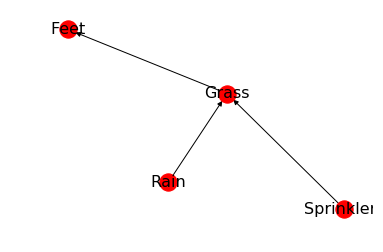

Rain
Sprinklers
Grass
Feet


In [3]:
# A demonstration for developers of how to create a BayesNet. In this example, I define the likelihood of getting
# wet feet as a function of wet grass, which is a function of raining and sprinkling.

# First, declare a bunch of nodes.
rain_node = BayesNode('Rain')
rain_node.set_marginal_distribution({True: 0.2, False: 0.8})
sprinklers_node = BayesNode('Sprinklers')
sprinklers_node.set_marginal_distribution({'on': 0.6, 'off': 0.4})
grass_node = BayesNode('Grass')
grass_node.add_entry([(rain_node, True), (sprinklers_node, 'on')], {'wet': 0.95, 'dry': 0.05})
grass_node.add_entry([(rain_node, True), (sprinklers_node, 'off')], {'wet': 0.6, 'dry': 0.4})
grass_node.add_entry([(rain_node, False), (sprinklers_node, 'on')], {'wet': 0.45, 'dry': 0.55})
grass_node.add_entry([(rain_node, False), (sprinklers_node, 'off')], {'wet': 0.1, 'dry': 0.90})
feet_node = BayesNode('Feet')
feet_node.add_entry([(grass_node, 'wet')], {'dry': 0.1, 'damp': 0.5, 'drenched': 0.4})
feet_node.add_entry([(grass_node, 'dry')], {'dry': 0.7, 'damp': 0.2, 'drenched': 0.1})

# Second, create a BayesNet object that just stores all the nodes.
net = BayesNet([rain_node, sprinklers_node, grass_node, feet_node])

# Third, do whatever you want with this data structure, like ask for the conditional distribution for a variable.
fetched_node = net.get_node('Feet')
assert fetched_node == feet_node  # Just a sanity check
# Calculate some joint probabilities
joint_prob = net.calc_joint([(rain_node, True), (sprinklers_node, 'off'), (feet_node, 'damp'), (grass_node, 'wet')])
print(joint_prob)

# Fourth, visualize it all. Right now, visualization is crude (weird layout) but should be correct (arrows the right way.)
net.draw_net()

# Fifth, show off a fancy new topographical ordering method I just wrote.
ordered_nodes = net.get_topographical_ordering()
for node in ordered_nodes:
    print(node.name)

Approximate Inference:

So far in this notebook, we've stuck with relatively small nets and simple distributions. That means that doing exact inference - calculating analytically exactly what some distribution will look like - is possible. For a lot of problems that we care about, though, exact inference isn't possible. There are lots of reasons this might happen: some distribution is wonky and therefore can't be reasoned about analytically, a net is so complex that doing all the math to marginalize out variables seems impossible, etc.

But we don't have to give up. In the following examples, we'll implement two sorts of approximate inference techniques: rejection sampling and Gibbs sampling.

In [41]:
def matches_evidence(node, value, evidence):
    for evidence_name, evidence_value in evidence:
        if node.name == evidence_name:
            if value == evidence_value:
                return True
            return False
    return True
    
# In this sampling method, we just generate random setups through sampling.
# If we satisfy the evidence, we save the state; if we don't we reject the sample and keep trying.
# After saving lots of states, the hope is that we have enough counts to estimate the frequencies of other variables
# conditioned on the evidence.
def rejection_sampling(X, e, net, num_samples=10000):
    # For each of the variables in X, store a count of how often each value in the domain appears.
    # Intialization to zero counts everywhere.
    var_to_val_to_count = {}
    for x in X:
        var_to_val_to_count[x] = {}
        for val in net.get_node(x).domain:
            var_to_val_to_count[x][val] = 0
    # Now, just generate tons of samples in the net, rejecting if it doesn't match the evidence.
    num_rejects = 0
    for sample_idx in range(num_samples):
        # Get a topographical ordering to start sampling.
        ordered_nodes = net.get_topographical_ordering()
        assignments = {}
        reject_sample = False
        for node in ordered_nodes:
            if node.marginal_distribution:
                sample = node.draw_sample()
                assignments[node] = sample
            else:
                parent_val_assignments = [(parent, assignments.get(parent)) for parent in node.parents]
                sample = node.draw_sample(parent_vals=parent_val_assignments)
                assignments[node] = sample
            # Do the rejection part if the node that was sampled contradicts the evidence
            if not matches_evidence(node, sample, e):
                reject_sample = True
                break
        if reject_sample:
            num_rejects += 1
            continue
        # Matched the evidence, so update the counts of valid variable assignments
        for assigned_node, assigned_val in assignments.items():
            if assigned_node.name in var_to_val_to_count.keys():
                var_to_val_to_count[assigned_node.name][assigned_val] += 1
    # At the end, finally have counts that we can use to compute probabilities.
    for x in X:
        relevant_counts = var_to_val_to_count.get(x)
        total_count = sum([count for count in relevant_counts.values()])
        normalized_distribution = {}
        for value, count in relevant_counts.items():
            normalized_distribution[value] = count / total_count
        print("Distribution for ", x, ":", normalized_distribution)
    print("Num samples used:", num_samples - num_rejects)
    print("Num samples rejected", num_rejects)

In [46]:
# Test the rejection sampling code.
# First, a really simple example.
rejection_sampling(['Feet'], [('Rain', False)], net)
# Now, a harder one, with more evidence and asking about more
rejection_sampling(['Rain', 'Grass'], [('Sprinklers', 'on'), ('Feet', 'drenched')], net)


Distribution for  Feet : {'dry': 0.5149197592778335, 'damp': 0.2938816449348044, 'drenched': 0.1911985957873621}
Num samples used: 7976
Num samples rejected 2024
Distribution for  Rain : {True: 0.2918011620400258, False: 0.7081988379599742}
Distribution for  Grass : {'wet': 0.8373143963847643, 'dry': 0.16268560361523562}
Num samples used: 1549
Num samples rejected 8451
